In [19]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
# Audio processing parameters
SAMPLE_RATE = 22050
N_MFCC = 40
MAX_PAD_LEN = 130  # Adjust based on the average length of your audio files

def extract_features(file_path, max_pad_len=MAX_PAD_LEN):
    """
    Loads an audio file, extracts MFCC features, and pads/truncates them to max_pad_len.
    """
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        # Pad or truncate to a fixed length
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [23]:
# Updatte his path to your dataset folder

DATASET_PATH = r"D:\Chinmay\ML PROJECTS\Music Genre Identifier\Data\genres_original"

features = []
labels = []

# List genre folders
genres = os.listdir(DATASET_PATH)
print("Detected genres:", genres)

# Loop over each genre folder and process .wav files
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)
        print(f"Processing genre '{genre}' with {len(files)} files.")
        for file in files:
            file_path = os.path.join(genre_path, file)
            if file_path.endswith('.wav'):
                mfcc = extract_features(file_path)
                if mfcc is not None:
                    features.append(mfcc)
                    labels.append(genre)

print(f"Extracted features from {len(features)} files.")


Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Processing genre 'blues' with 83 files.
Processing genre 'classical' with 100 files.
Processing genre 'country' with 100 files.
Processing genre 'disco' with 100 files.
Processing genre 'hiphop' with 100 files.
Processing genre 'jazz' with 100 files.


C:\Users\CHINMAY\AppData\Local\Temp\ipykernel_7420\2773270764.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)


Error processing D:\Chinmay\ML PROJECTS\Music Genre Identifier\Data\genres_original\jazz\jazz.00054.wav: 
Processing genre 'metal' with 100 files.
Processing genre 'pop' with 100 files.
Processing genre 'reggae' with 100 files.
Processing genre 'rock' with 100 files.
Extracted features from 982 files.


In [24]:
X = np.array(features)  # Shape: (num_samples, N_MFCC, MAX_PAD_LEN)
y = np.array(labels)

print("Feature array shape:", X.shape)
print("Labels shape:", y.shape)


Feature array shape: (982, 40, 130)
Labels shape: (982,)


In [27]:
# Encode string labels into integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Encoded genres:", encoder.classes_)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Encoded genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Training samples: 785
Test samples: 197


In [29]:
X_train = X_train[..., np.newaxis]  # New shape: (num_samples, N_MFCC, MAX_PAD_LEN, 1)
X_test = X_test[..., np.newaxis]

print("Training data shape after reshaping:", X_train.shape)


Training data shape after reshaping: (785, 40, 130, 1)


In [31]:
num_genres = len(encoder.classes_)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(N_MFCC, MAX_PAD_LEN, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_genres, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 38, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 19, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 31, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 31, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15872)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       2,031,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,850 (7.83 MB)

 Trainable params: 2,051,850 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.1240 - loss: 16.4283 - val_accuracy: 0.1338 - val_loss: 2.2998
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.1853 - loss: 2.2405 - val_accuracy: 0.0892 - val_loss: 2.3051
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.1987 - loss: 2.1966 - val_accuracy: 0.1656 - val_loss: 2.2607
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.2292 - loss: 2.1054 - val_accuracy: 0.1911 - val_loss: 2.1159
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.2766 - loss: 1.9392 - val_accuracy: 0.2166 - val_loss: 1.9816
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3822 - loss: 1.7592 - val_accuracy: 0.3312 - val_loss: 1.8287
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3548 - loss: 1.7509 - val_accuracy: 0.3057 - val_loss: 1.8956
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4493 - loss: 1.5573 - val_accuracy: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3025 - loss: 1.7985
Test Accuracy: 37.06%
Test Loss: 1.7074


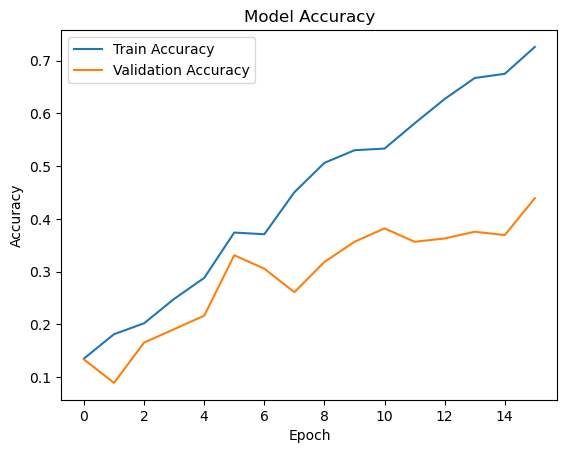

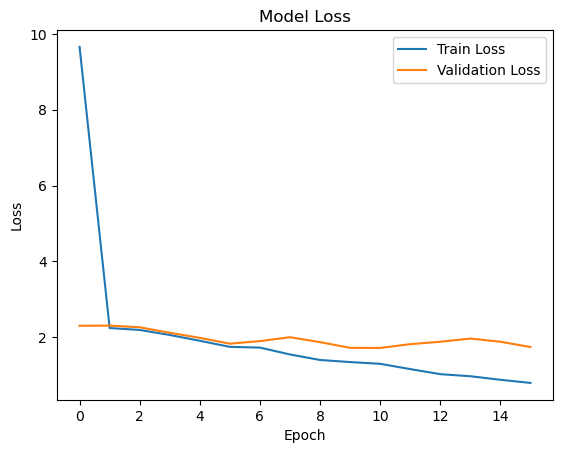

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [45]:
def predict_genre(file_path):
    mfcc = extract_features(file_path)
    if mfcc is not None:
        mfcc = mfcc.reshape(1, N_MFCC, MAX_PAD_LEN, 1)
        prediction = model.predict(mfcc)
        predicted_index = np.argmax(prediction)
        predicted_genre = encoder.inverse_transform([predicted_index])[0]
        return predicted_genre
    else:
        return "Error processing file."

# Example usage (update with an actual file path from your dataset)
new_audio_file = r"D:\Chinmay\ML PROJECTS\Music Genre Identifier\Data\genres_original\classical\classical.00012.wav"
print("Predicted Genre:", predict_genre(new_audio_file))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Genre: classical


In [ ]:
with open('fake_news_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load vectorizer
with open('vectorizer.pkl', 'rb') as file:
    loaded_vectorizer = pickle.load(file)

# Test with a new example
new_text = ["This is a fake news example."]
new_text_tfidf = loaded_vectorizer.transform(new_text)
prediction = loaded_model.predict(new_text_tfidf)

if prediction[0] == 1:
    print("Real News")
else:
    print("Fake News")